# Bright Machines Pick and Place Demo

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pathlib
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

from torchsummary import summary

from pick_place.models.resnet import ResNet18
from pick_place.models.scnn import SiameseCNN
from pick_place.utils.configs import Configs
from pick_place.datasets.image_position_dataset import ImagePositionDataset

/home/prabhune/miniconda3/envs/clipreid/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gpu on which the model will evaluate test points
device = 0

### ResNet18 Evaluation

In [3]:
dataset_path = "/data/brightmachines/dataset/"

In [4]:
### Model Initialization ###

# path to folder storing checkpoints of the model weights to use for evaluation
ckpt_path = pathlib.Path("../ckpts/resnet_transf_l1/")
# update below to use different model checkpoints
ckpt = ckpt_path  / "resnet_transf_l1_best.pth"
config = ckpt_path / "resnet_transf_l1.yml"

resnet_config = Configs.load_config(config)

model = Configs.load_model(resnet_config, ckpt).to(device)

In [5]:
### Data Loading ###

data = ImagePositionDataset(
    dataset_path=f"/data/brightmachines/dataset/",
    label_name="xyr", 
    use_transform=False)

train_data, val_data, test_data = Configs.load_dataset(resnet_config)

In [13]:
### Model Evaluation ###

# random test points selected, can be modified to test specific images
test_points = np.random.choice(len(test_data), size=5, replace = False)


for pt in test_points:
    assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

for pt in test_points:
    image, label = test_data[pt]
    image = image.to(device).unsqueeze(0)
    label = data[0][1] - label
    label = label.numpy()

    pred = model(image).squeeze(0)
    pred = pred.detach().cpu().numpy()

    plt.imshow(image.detach().cpu().squeeze(0).squeeze(0), cmap="gray")
    plt.show()
    print(f"Test Image Index: {pt}")
    print(f"Prediction: {pred}")
    print(f"Ground Truth: {label}")
    print(f"Delta: {label - pred}")

RuntimeError: CUDA error: invalid device function

In [7]:
### Evaluation Speed Testing ###
num_points = 100
test_points = np.random.choice(len(test_data), size=num_points, replace = False)

for pt in test_points:
    assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

deltas = np.zeros((num_points, 3))
i = 0
start_time = time.time()
for pt in test_points:
    image, label = test_data[pt]
    image = image.to(device).unsqueeze(0)
    label = data[0][1] - label
    label = label.numpy()

    pred = model(image).squeeze(0)
    pred = pred.detach().cpu().numpy()
    delta = label - pred
    deltas[i] = delta
    i += 1
end_time = time.time()

print()
print(f"Time taken to evaluate {len(test_points)} test points: {round(end_time - start_time, 2)}s")
print(f"Time taken per test point: {round((end_time - start_time) / len(test_points), 3)}s")

print()
print(f"average L1 errors: {np.mean(np.abs(deltas), axis = 0)}")
print(f"total average L1 error: {np.mean(np.abs(deltas))}")

RuntimeError: CUDA error: invalid device function

In [8]:
print(summary(model, data[0][0].shape, device=torch.device(0)))

AttributeError: 'torch.device' object has no attribute 'lower'

### SiameseCNN Evaluation

In [2]:
### Model Initialization ###
device = 5
# path to folder storing checkpoints of the model weights to use for evaluation
ckpt_path = pathlib.Path("/data/brightmachines/ckpts/resnetakaze/")
# update below to use different model checkpoints
ckpt = ckpt_path / "scnn_resnetakaze_scnn_244.15.pth"
config = ckpt_path / "resnetakaze.yml"

# data_xyr_1 ckpt
xyr1_ckpt_path = pathlib.Path("../ckpts/scnn_l1/")
xyr1_ckpt = xyr1_ckpt_path / "scnn_l1_best.pth"
xyr1_config = xyr1_ckpt_path / "scnn_l1.yml"

# data_xyr_2 ckpt
xyr2_ckpt_path = pathlib.Path("../ckpts/scnn_l1_2/")
xyr2_ckpt = xyr2_ckpt_path / "scnn_l1_best.pth"
xyr2_config = xyr2_ckpt_path / "scnn_l1_2.yml"

# data_xyr_3 ckpt
xyr3_ckpt_path = pathlib.Path("../ckpts/scnn_l1_3/")
xyr3_ckpt = xyr3_ckpt_path / "scnn_l1_best.pth"
xyr3_config = xyr3_ckpt_path / "scnn_l1_3.yml"

# data_xyr_3_crop ckpt
xyr3_c_ckpt_path = pathlib.Path("../ckpts/scnn_l1_3_crop/")
xyr3_c_ckpt = xyr3_c_ckpt_path / "scnn_l1_best.pth"
xyr3_c_config = xyr3_c_ckpt_path / "scnn_l1_3.yml"

scnn_config  = Configs.load_config(config)
xyr1_config = Configs.load_config(xyr1_config)
xyr2_config = Configs.load_config(xyr2_config)
xyr3_config = Configs.load_config(xyr3_config)
xyr3_c_config = Configs.load_config(xyr3_c_config)
model = Configs.load_model(scnn_config, ckpt).to(device)

resnetakaze
resnetakaze
here


/home/prabhune/miniconda3/envs/clipreid/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prabhune/miniconda3/envs/clipreid/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
xyr1_config['dataset_params']['crop'] = 500
xyr2_config['dataset_params']['crop'] = 500
scnn_config['dataset_params']['crop'] = 500

In [3]:
### Data Loading ###
train_data, val_data, test_data = Configs.load_dataset(scnn_config)
_, _, xyr1_data = Configs.load_dataset(xyr1_config)
_, _, xyr2_data = Configs.load_dataset(xyr2_config)
_, _, xyr3_data = Configs.load_dataset(xyr3_config)

test_data = xyr1_data
#train_data, val_data, test_data = Configs.load_dataset(xyr1_config)

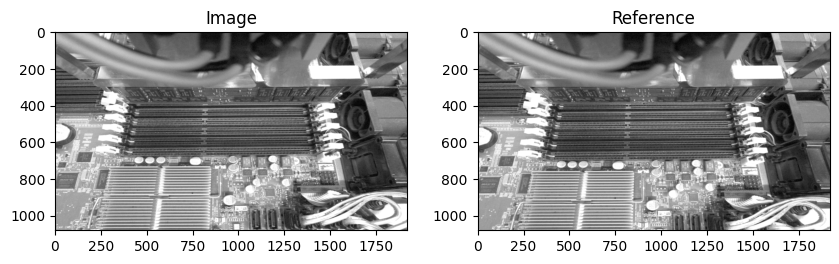

Test Image Index: 646
Prediction: [-395.4512   129.3997   115.41296]
Ground Truth: [ 0. -4.  0.]
Delta: [ 395.4512  -133.3997  -115.41296]



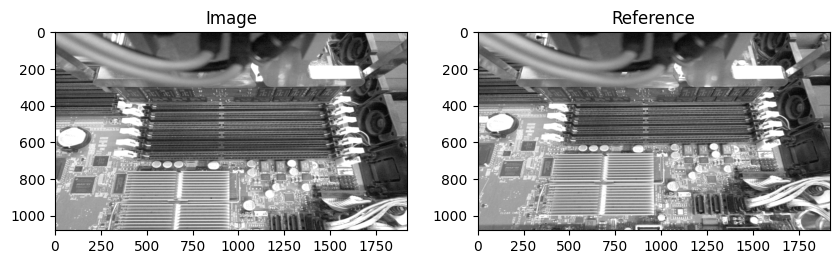

Test Image Index: 293
Prediction: [ 496.99942 -277.15942 -281.48303]
Ground Truth: [ 1.   15.5  -0.25]
Delta: [-495.99942  292.65942  281.23303]



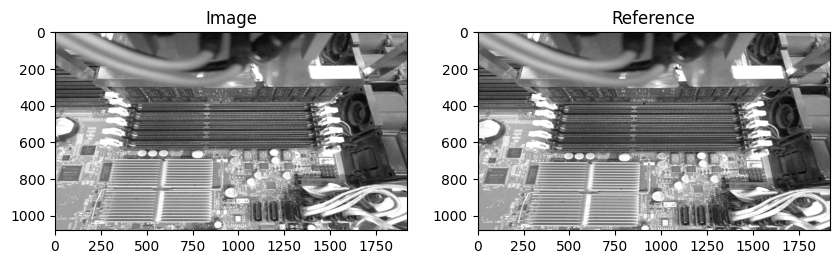

Test Image Index: 8
Prediction: [-171.18915   95.98933  187.80133]
Ground Truth: [ 3.   -3.    0.25]
Delta: [ 174.18915  -98.98933 -187.55133]



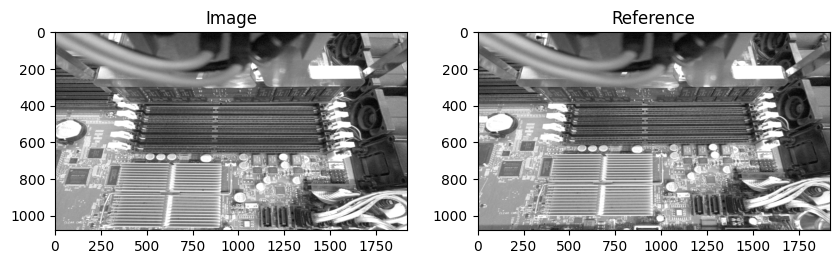

Test Image Index: 620
Prediction: [ 181.71382    40.215633 -667.3181  ]
Ground Truth: [ 5.    8.5  -0.75]
Delta: [-176.71382   -31.715633  666.5681  ]



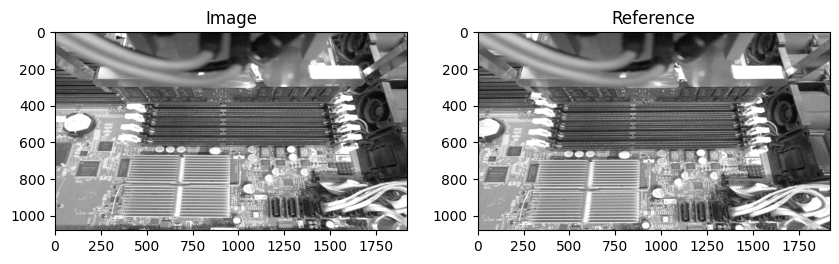

Test Image Index: 79
Prediction: [ 314.135   -144.57257 -447.74106]
Ground Truth: [-10.    -3.5   -0.75]
Delta: [-324.135    141.07257  446.99106]



In [4]:
### Model Evaluation ###

# random test points selected, can be modified to test specific images
np.random.seed(0)
test_points = np.random.choice(len(test_data), size=5, replace = False)

for pt in test_points:
    assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

for pt in test_points:
    image, reference, label = test_data[pt]
    image = image.to(0).unsqueeze(0)
    reference = reference.to(0).unsqueeze(0)
    label = label.numpy()

    pred = model(image, reference).squeeze(0)
    pred = pred.detach().cpu().numpy()

    fig, axarr = plt.subplots(1, 2, figsize = (10, 10))
    axarr[0].imshow(image.detach().cpu().squeeze(0)[0].int(), cmap="gray",)
    axarr[0].set_title("Image")
    axarr[1].imshow(reference.detach().cpu().squeeze(0)[0].int(), cmap="gray")
    axarr[1].set_title("Reference")
    plt.show()
    print(f"Test Image Index: {pt}")
    print(f"Prediction: {pred}")
    print(f"Ground Truth: {label}")
    print(f"Delta: {label - pred}")
    print()

In [6]:
### Evaluation Speed Testing ###
def eval_speed():
    num_points = 100
    test_points = np.random.choice(len(test_data), size=num_points, replace = False)

    for pt in test_points:
        assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

    deltas = np.zeros((num_points, 3))
    i = 0
    start_time = time.time()
    for pt in test_points:
        image, reference, label = test_data[pt]
        image = image.to(device).unsqueeze(0)
        reference = reference.to(device).unsqueeze(0)
        label = label.numpy()

        pred = model(image, reference).squeeze(0)
        pred = pred.detach().cpu().numpy()
        delta = label - pred
        deltas[i] = delta
        i += 1
    end_time = time.time()

    print()
    print(f"Time taken to evaluate {len(test_points)} test points: {round(end_time - start_time, 2)}s")
    print(f"Time taken per test point: {round((end_time - start_time) / len(test_points), 3)}s")

    print()
    print(f"average L1 errors: {np.mean(np.abs(deltas), axis = 0)}")
    print(f"total average L1 error: {np.mean(np.abs(deltas))}")

test_data = xyr1_data
eval_speed()
test_data = xyr2_data
eval_speed()
test_data = xyr3_data
eval_speed()


Time taken to evaluate 100 test points: 99.69s
Time taken per test point: 0.997s

average L1 errors: [0.2872135  0.31197872 0.6568556 ]
total average L1 error: 0.41868260730678836

Time taken to evaluate 100 test points: 105.66s
Time taken per test point: 1.057s

average L1 errors: [2.43823512 7.088135   0.70029029]
total average L1 error: 3.4088868051953614

Time taken to evaluate 100 test points: 94.93s
Time taken per test point: 0.949s

average L1 errors: [3.92546016 6.82007622 0.5005798 ]
total average L1 error: 3.7487053933491308


### Iterative Process

In [36]:
data = ImagePositionDataset(
	dataset_path=f"/data/brightmachines/data_xyr/", 
	label_name="xyr_3", 
    img_height=1080,
    img_width=1920,
	use_transform=False,
    crop=500)

In [37]:
def find_nearest_image(position):
    def closest_item(lst, K):
        return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    x_decimals = [0.177, 0.677]
    K = position[0] % 1
    position[0] = position[0] // 1 + closest_item(x_decimals, K)
    
    y_decimals = [0.42, 0.92]
    K = position[1] % 1
    position[1] = position[1] // 1 + closest_item(y_decimals, K)

    r_decimals = [0, 0.25, 0.5, 0.75]
    K = position[2] % 1
    position[2] = position[2] // 1 + closest_item(r_decimals, K)

    return position

In [38]:
### Iterative Loop ###

# "take a picture"
image, reference = np.random.choice(len(data), size=2, replace = False)
image, position = data[image]
position = np.array(position)
reference, goal = data[reference]
goal = np.array(goal)
print(f"initial position: {position}")
print(f"reference position: {goal}")
print()

# model expects images with 3 channels
image = image.repeat(3, 1, 1).to(device).unsqueeze(0)
reference = reference.repeat(3, 1, 1).to(device).unsqueeze(0)

# five iterations
#TODO modify so that it terminates when movements are smaller than some threshold
for i in range(5):
    # model output how to move the arm to position
    print(f"iteration: {i + 1}")
    delta_pos = model(image, reference)[0].detach().cpu()
    delta_pos = np.array(delta_pos)
    print(f"{delta_pos} : amount to move arm")

    # shrink movements that are bigger than a certain threshold to avoid overshooting
    for i in range(len(delta_pos)):
        if delta_pos[i] >= 1:
            delta_pos[i] = delta_pos[i] * 0.8 

    # TODO Add code here which moves the robot arm
    for i in range(len(delta_pos)):
        position[i] += delta_pos[i]
    print(f"{position} : updated position")
    print(f"{goal} : reference position")
    print(f"{[abs(position[i] - goal[i]) for i in range(3)]} : distance from reference:")
    
    # need to find a picture in the dataset, so need to find nearest image in dataset
    # ignore for robot movements
    position = find_nearest_image(position)
    print(f"{position} : nearest image to the updated position")

    # TODO "take a picture" at the new position
    #print(f"image path: {position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    if image == None:
        image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}000000000002_-850_1.0_0_{position[2]}")
        if image == None:
            raise Exception("No nearest image found")
    image = image.repeat(3, 1, 1).to(device).unsqueeze(0).float()
    print()

initial position: [ 516.291  -86.693 -179.835]
reference position: [ 516.291  -81.693 -179.335]

iteration: 1
[ 0.07493684  4.9461956  -0.13648629] : amount to move arm
[ 516.36597   -82.736046 -179.9715  ] : updated position
[ 516.291  -81.693 -179.335] : reference position
[0.07495117, 1.043045, 0.63648987] : distance from reference:
[ 516.177  -82.58  -180.   ] : nearest image to the updated position
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.177_-82.58_-850_1.0_0_-180.0.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.177_-82.58000000000002_-850_1.0_0_-180.0.png'


Exception: No nearest image found

In [15]:
### Iterative Loop Graphing ###

# "take a picture"
image, reference = np.random.choice(len(data), size=2, replace = False)
image, position = data[image]
position = np.array(position)
reference, goal = data[reference]
goal = np.array(goal)
iterations = 10
x_errors = [abs(position[0] - goal[0])]
y_errors = [abs(position[1] - goal[1])]
r_errors = [abs(position[2] - goal[2])]
l1_errors = [x_errors[0] + y_errors[0] + r_errors[0]]

# model expects images with 3 channels
image = image.repeat(3, 1, 1).to(device).unsqueeze(0)
reference = reference.repeat(3, 1, 1).to(device).unsqueeze(0)

for i in range(iterations):
    # model output how to move the arm to position
    print(image.shape, reference.shape)
    delta_pos = model(image, reference)[0].detach().cpu()
    delta_pos = np.array(delta_pos)

    # shrink movements that are bigger than a certain threshold to avoid overshooting
    # for i in range(len(delta_pos)):
    #     if abs(delta_pos[i]) >= 0.5:
    #         delta_pos[i] = delta_pos[i] * 0.8 

    # TODO Add code here which moves the robot arm
    for i in range(len(delta_pos)):
        position[i] += delta_pos[i]

    x_error = abs(position[0] - goal[0])
    y_error = abs(position[1] - goal[1])
    r_error = abs(position[2] - goal[2])
    l1_error = x_error + y_error + r_error

    x_errors.append(x_error)
    y_errors.append(y_error)
    r_errors.append(r_error)
    l1_errors.append(l1_error)
    
    # need to find a picture in the dataset, so need to find nearest image in dataset
    # ignore for robot movements
    position = find_nearest_image(position)

    # "take a picture" at the new position
    #print(f"image path: {position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    if image == None:
        image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}000000000002_-850_1.0_0_{position[2]}")
        if image == None:
            print("No nearest image found")
            continue
    image = image.repeat(3, 1, 1).to(device).unsqueeze(0).float()

plt.plot(range(iterations + 1), x_errors, label = "x error")
plt.plot(range(iterations + 1), y_errors, label = "y error")
plt.plot(range(iterations + 1), r_errors, label = "r error")
plt.plot(range(iterations + 1), l1_errors, label = "total L1 error")
plt.title("Errors vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("L1 Error")
plt.legend()
plt.show()

torch.Size([1, 3, 1080, 1920]) torch.Size([1, 3, 1080, 1920])
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-77.58_-850_1.0_0_-180.5.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-77.58000000000002_-850_1.0_0_-180.5.png'
No nearest image found


AttributeError: 'NoneType' object has no attribute 'shape'

[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.177_-81.58_-850_1.0_0_-179.75.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.177_-81.58000000000002_-850_1.0_0_-179.75.png'
515.177_-81.58_-850_1.0_0_-179.75
No nearest image found #1
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.677_-78.58_-850_1.0_0_-180.25.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.677_-78.58000000000002_-850_1.0_0_-180.25.png'
515.677_-78.58_-850_1.0_0_-180.25
No nearest image found #2
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-73.08_-850_1.0_0_-180.75.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-73.08000000000002_-850_1.0_0_-180.75.png'
516.677_-73.08_-850_1.0_0_-180.75
No nearest image found #3
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr

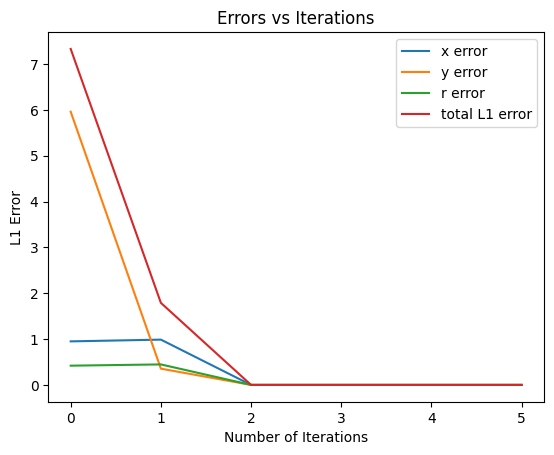

In [39]:
number_tests = 100
iterations = 5
x_errors = np.zeros(iterations + 1)
y_errors = np.zeros(iterations + 1)
r_errors = np.zeros(iterations + 1)
l1_errors = np.zeros(iterations + 1)
num_not_found = 1

for _ in range(number_tests):
    # "take a picture"
    image, reference = np.random.choice(len(data), size=2, replace = False)
    image, position = data[image]
    position = np.array(position)
    reference, goal = data[reference]
    goal = np.array(goal)
    x_error = abs(position[0] - goal[0])
    y_error = abs(position[1] - goal[1])
    r_error = abs(position[2] - goal[2])
    l1_error = x_error + y_error + r_error

    x_errors[0] += x_error
    y_errors[0] += y_error
    r_errors[0] += r_error
    l1_errors[0] += l1_error

    # model expects images with 3 channels
    image = image.repeat(3, 1, 1).to(device).unsqueeze(0)
    reference = reference.repeat(3, 1, 1).to(device).unsqueeze(0)

    for iter in range(iterations):
        # model output how to move the arm to position
        if image == None:
            continue
        delta_pos = model(image, reference)[0].detach().cpu()
        delta_pos = np.array(delta_pos)

        # shrink movements that are bigger than a certain threshold to avoid overshooting
        # for i in range(len(delta_pos)):
        #     if abs(delta_pos[i]) >= 0.5:
        #         delta_pos[i] = delta_pos[i] * 0.8 

        # TODO Add code here which moves the robot arm
        for i in range(len(delta_pos)):
            position[i] += delta_pos[i]

        x_error = abs(position[0] - goal[0])
        y_error = abs(position[1] - goal[1])
        r_error = abs(position[2] - goal[2])
        l1_error = x_error + y_error + r_error

        x_errors[iter+1] += x_error
        y_errors[iter+1] += y_error
        r_errors[iter+1] += r_error
        l1_errors[iter+1] += l1_error
        
        # need to find a picture in the dataset, so need to find nearest image in dataset
        # ignore for robot movements
        position = find_nearest_image(position)

        # "take a picture" at the new position
        #print(f"image path: {position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
        image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
        if image == None:
            image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}000000000002_-850_1.0_0_{position[2]}")
            if image == None:
                print(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
                print(f"No nearest image found #{num_not_found}")
                num_not_found += 1
                continue
        image = image.repeat(3, 1, 1).to(device).unsqueeze(0).float()

for i in range(iterations + 1):
    x_errors[i] = x_errors[i] / number_tests
    y_errors[i] = y_errors[i] / number_tests
    r_errors[i] = r_errors[i] / number_tests
    l1_errors[i] = l1_errors[i] / number_tests

plt.plot(range(iterations + 1), x_errors, label = "x error")
plt.plot(range(iterations + 1), y_errors, label = "y error")
plt.plot(range(iterations + 1), r_errors, label = "r error")
plt.plot(range(iterations + 1), l1_errors, label = "total L1 error")
plt.title("Errors vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("L1 Error")
plt.legend()
plt.show()

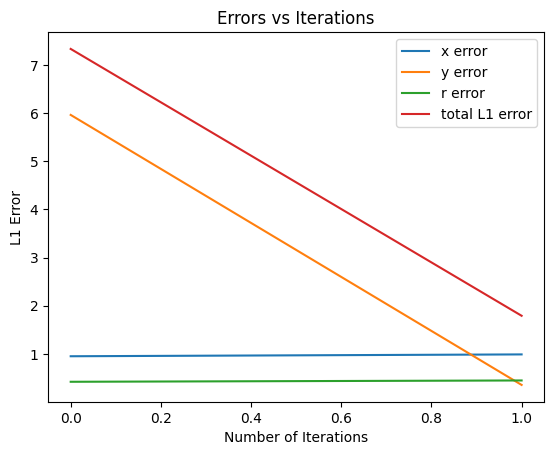

In [41]:
plt.plot(range(2), x_errors[:2], label = "x error")
plt.plot(range(2), y_errors[:2], label = "y error")
plt.plot(range(2), r_errors[:2], label = "r error")
plt.plot(range(2), l1_errors[:2], label = "total L1 error")
plt.title("Errors vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("L1 Error")
plt.legend()
plt.show()

In [21]:
for i in range(1, iterations + 1):
    print(f"{i} iterations:")
    print(f"l1 errors = [{x_errors[i]:.3f} {y_errors[i]:.3f} {r_errors[i]:.3f}]")
    print(f"average l1_error = {l1_errors[i] / 3:.3f}")
    print()

1 iterations:
l1 errors = [0.246 0.530 0.359]
average l1_error = 0.378

2 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

3 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

4 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

5 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000



In [33]:
import cv2

akaze = cv2.AKAZE_create()


image = train_data[4][0]

kpts, desc = akaze.detectAndCompute(image[0].numpy(), None)
desc.shape

(46068, 61)

In [3]:
### Model Initialization ###
device = 4
# path to folder storing checkpoints of the model weights to use for evaluation
ckpt_path = pathlib.Path("/data/brightmachines/ckpts/")
# update below to use different model checkpoints
model_ckpt = ckpt_path / "akaze" / "scnn_akaze_scnn_0.87.pth"
model_conf = ckpt_path / "akaze" / "akaze.yml"

# data_xyr_1 ckpt
xyr1_ckpt_path = pathlib.Path("../ckpts/scnn_l1/")
xyr1_config = xyr1_ckpt_path / "scnn_l1.yml"

# data_xyr_2 ckpt
xyr2_ckpt_path = pathlib.Path("../ckpts/scnn_l1_2/")
xyr2_config = xyr2_ckpt_path / "scnn_l1_2.yml"

# data_xyr_3_crop ckpt
xyr3_c_ckpt_path = pathlib.Path("../ckpts/scnn_l1_3_crop/")
xyr3_c_config = xyr3_c_ckpt_path / "scnn_l1_3.yml"

model_config  = Configs.load_config(model_conf)
xyr1_config = Configs.load_config(xyr1_config)
xyr2_config = Configs.load_config(xyr2_config)
xyr3_c_config = Configs.load_config(xyr3_c_config)
model = Configs.load_model(model_config, ckpt=model_ckpt).to(device)

akaze


FileNotFoundError: [Errno 2] No such file or directory: '/data/brightmachines/ckpts/akaze/scnn_akaze_scnn_0.87.pth'

In [6]:
train_data, val_data, test_data = Configs.load_dataset(model_config)
_, _, xyr1_data = Configs.load_dataset(xyr1_config)
_, _, xyr2_data = Configs.load_dataset(xyr2_config)
_, _, xyr3_data = Configs.load_dataset(model_config)

In [4]:
model(train_data[2][0].unsqueeze(0).to(device), train_data[2][1].unsqueeze(0).to(device))

tensor([[  0.5794, -16.3639,   0.8236]], device='cuda:4',
       grad_fn=<AddmmBackward>)

In [5]:
train_data[2]

(tensor([[[161., 162., 161.,  ..., 130., 130., 131.],
          [162., 164., 164.,  ..., 133., 133., 132.],
          [165., 165., 166.,  ..., 133., 133., 133.],
          ...,
          [138., 140., 138.,  ...,  42.,  42.,  42.],
          [136., 135., 134.,  ...,  41.,  41.,  38.],
          [139., 136., 133.,  ...,  36.,  34.,  30.]],
 
         [[161., 162., 161.,  ..., 130., 130., 131.],
          [162., 164., 164.,  ..., 133., 133., 132.],
          [165., 165., 166.,  ..., 133., 133., 133.],
          ...,
          [138., 140., 138.,  ...,  42.,  42.,  42.],
          [136., 135., 134.,  ...,  41.,  41.,  38.],
          [139., 136., 133.,  ...,  36.,  34.,  30.]],
 
         [[161., 162., 161.,  ..., 130., 130., 131.],
          [162., 164., 164.,  ..., 133., 133., 132.],
          [165., 165., 166.,  ..., 133., 133., 133.],
          ...,
          [138., 140., 138.,  ...,  42.,  42.,  42.],
          [136., 135., 134.,  ...,  41.,  41.,  38.],
          [139., 136., 133.,  .

In [8]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
import torchvision

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = train_data[0][0]

processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb8')
model = ViTModel.from_pretrained('facebook/dino-vitb8')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
emb = outputs.last_hidden_state
print(emb.shape)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 785, 768])


In [ ]:
attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

In [18]:
torch.nn.Linear(emb.shape[2], 3)(emb).shape
resnet = torchvision.models.resnet18(pretrained=True)

/home/prabhune/miniconda3/envs/clipreid/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prabhune/miniconda3/envs/clipreid/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/prabhune/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 377MB/s]


In [26]:
resnet(torch.tensor(np.array(image).transpose(2, 0, 1)).unsqueeze(0).float()).shape

torch.Size([1, 1000])

In [6]:
from transformers import pipeline
pipe = pipeline(task="depth-estimation", model="Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


(-0.5, 2591.5, 1943.5, -0.5)

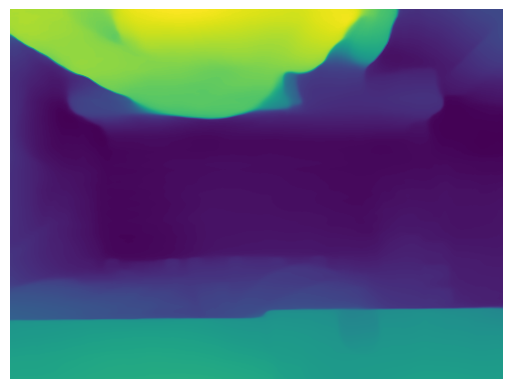

In [9]:
plt.imshow(pipe("/data/brightmachines/data_xyr/data_xyr_2/573.086_-68.485_-859.64_0.062_-0.017_177.89.png")['depth'])
plt.axis('off')